# Сборный проект. Оценка закономерностей популярности компьютерных игр для планирования рекламной кампании на 2017 год

В последнее время всё больше появляется платформ для игр, также популярность набирают игры на мобильные телефоны, за счет этого конкуренция на рынке растет. И перед нами стоит задача определиться, какой же продукт наиболее популярен среди пользователей, чтобы составить план рекламной компании. Данное исследование проводится для интернет-магазина "Стримчик". 

**Цель**: выявить наиболее перспективные игровые платформы, определиться с портретами пользователей для планирования рекламной кампании на 2017 год и оценить, какие факторы могут влиять на популярность игр среди пользователей.

**Описание данных:**
Данные получены их открытых источников.

Name — название игры \
Platform — платформа \
Year_of_Release — год выпуска \
Genre — жанр игры \
NA_sales — продажи в Северной Америке (миллионы проданных копий) \
EU_sales — продажи в Европе (миллионы проданных копий) \
JP_sales — продажи в Японии (миллионы проданных копий) \
Other_sales — продажи в других странах (миллионы проданных копий) \
Critic_Score — оценка критиков (максимум 100) \
User_Score — оценка пользователей (максимум 10) \
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Ход исследования:**
1. Общее ознакомление с данными
2. Предобработка данных
3. Исследовательский анализ
4. Составление портрета пользователя по регионам
5. Проверка гипотез
6. Формирование выводов

## Шаг 1: Изучение общей информации о данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')
from scipy import stats as st #загружаем библиотеки в отдельной ячейке

In [3]:
try:
    games = pd.read_csv('games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')
games.head(10) #посмотрим первые 10 строк датафрейма

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Уже при обзоре данных заметны пропуски в некоторых столбцах, а также не совсем точно выбранный тип данных, например, в столбце года выпуска. Сейчас посмотрим общую информацию о пропусках и типах данных:

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


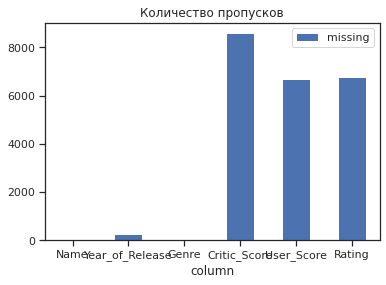

In [5]:
miss_data = games.isna().sum(axis=0).reset_index()
miss_data.columns = ['column', 'missing']
miss_data = miss_data[miss_data['missing'] != 0]
miss_data['percent'] = (miss_data['missing'] / len(games))*100
miss_data.plot.bar(x='column', y='missing', rot=0, title='Количество пропусков');

Из общей информации видно, что большее количество пропусков в столбцах с рейтингами. Для удобства восприятия представила информацию о количестве пропусков в виде столбчатой диаграммы. В двух строках пропущены данные о жанре и о названии игры, небольшое количество пропусков в столбце с годом выпуска. 
Также в глаза бросается тип данных float в столбце с годом релиза и оценкой критиков (после запятой там 0, значит, значения целые), а также возникает вопрос по поводу типа object в столбце пользовательского рейтинга.

Посмотрим на наличие дубликатов в данных:

In [6]:
games.duplicated().sum()

0

Явных дубликатов нет - это уже хорошо. Значит, наша задача разобраться с типами данных и с пропусками в определенных столбцах.

## Шаг 2: Предобработка данных

Перед тем, как проводить предобработку, сохраним размер датафрейма, чтобы сравнить после.

In [7]:
old_df = games

Для начала для удобства дальнейшей работы приведем все названия столбцов к нижнему регистру:

In [8]:
games.columns = games.columns.str.lower()

In [9]:
games.columns #посмотрим, что получилось

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 2.1 Работа с пропусками

Теперь проверим, в каких строках пропущенны названия и жанры:

In [10]:
games.loc[(games['name'].isna()) & (games['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Хм, в одних и тех же строках с низкими или нулевыми продажами. Очень неинформативные строки, к тому же с большим количеством пропусков, по которым сложно будет провести какой-либо анализ. Мы может удалить их из датафрейма без последствий.
Это старые игры на сегу, возможно, пропуски здесь связаны с тем, что не сохранились названия данных игр ввиду их непопулярности, нет оценок, вероятно, тк этих данных также не было, они утеряны или вообще игра не оценивалась, например, ESRB появилась позже (в 1994 году).

In [11]:
games = games.dropna(subset=['name']).reset_index(drop=True)
games.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

Посмотрим, в каких играх пропущен год выхода, может быть, эти игры еще не выпустили, они только ожидаются.

In [12]:
miss_date = games.query('year_of_release.isna()')
miss_date

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Первая мысль, которая возникла, глядя на эти пропуски - заполнить год выпуска годом из названия, если такой есть. Однако, есть нюанс: что игры выходят на разные платформы в разные годы, а также есть свои особенности релиза, например, FIFA выходит за год (то есть 2004 выходит в 2003), а вот дартс выходит в этот же год. Поэтому такое заполнение будет не совсем точным.

Посмотрим, есть ли игры, где помимо года выпуска пропущены и другие значения:

In [13]:
games.query('year_of_release.isna() and user_score.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
1300,Triple Play 99,PS,NaN,Sports,0.81,0.55,0.00,0.10,NaN,NaN,NaN
1505,Adventure,2600,NaN,Adventure,1.21,0.08,0.00,0.01,NaN,NaN,NaN
1584,Combat,2600,NaN,Action,1.17,0.07,0.00,0.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16178,WRC: FIA World Rally Championship,PC,NaN,Racing,0.00,0.01,0.00,0.00,65.0,NaN,RP
16291,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16327,Brothers in Arms: Furious 4,X360,NaN,Shooter,0.01,0.00,0.00,0.00,NaN,NaN,M
16346,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN


Да, обращает на себя внимание такое количество пропусков в некоторых строках. Я решила не удалять все пропуски в этом столбце, однако избавиться от тех строк, где пропуски во многих столбцах, к тому же у таких игр еще и довольно низкие продажи. Остальные игры с пропусками в дате релиза оставим, они могут понадобиться для анализа. 

In [14]:
games = games.loc[~(games['year_of_release'].isna() & (games['user_score'].isna()))]

In [15]:
games.isna().sum()

name                  0
platform              0
year_of_release     175
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8487
user_score         6605
rating             6679
dtype: int64

Остается внушительное количество пропусков в оценках критиков, пользователей и рейтинге от ESRB. Но в данном случае будет некорректно заполнять их медианой или средним, так как всё-таки эти показатели индивидуальны для каждой игры и не зависят от жанра или чего-либо еще. Мы не можем решать за пользователя или критика, это исказит всю картину.
Пропуски в рейтинге ESRB вполне объяснимы: ряд игр в датафрейме вышел до появления этой организации, также не все игры имеют этот рейтинг, так как ESRB - организация Северной Америки и Канады, игры, которые выходят в других странах и направлены на рынок там могут не иметь их оценки, а иметь оценку от своей внутренней подобной организации. \
Пропуски в остальных оценках могут быть связаны с выгрузкой данных, какие-то технические проблемы, очень большое количество пропусков. \
Сейчас нужно разобраться с типом данных. Для начала посмотрим, почему в столбце `user_score` тип object, значит, там содержатся какие-то строковые значения.

In [16]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Вот и "белая ворона" среди данных - строковое значение tbd. После непродолжительного поиска в интернете стало понятно, что аббревиатура TBD расшифровывается как to be determinate - то есть оценка еще не определена. Может быть, эти игры вышли недавно, еще недостаточное количество данных, а, может быть, данные об оценки пользователей просто отсутствуют ввиду непопулярности или давней даты выпуска. Посмотрим, что это за строки:

In [17]:
print(len(games.query('user_score == "tbd"')))
len(games.query('user_score == "tbd" and year_of_release > 2015'))

2424


34

Да, действительно есть относительно новые игры с оценкой tbd, однако это далеко не все из них, поэтому проблема, скорее всего, не только с недавней датой выпуска, но и связана с выгрузкой или отсутствием данных.
Чтобы в дальнейшем строковые значения не помешали проводить анализ, заменим значения tbd на NaN:

In [18]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.NaN
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [19]:
games.isna().sum() #пропусков в оценках пользователей должно стать больше

name                  0
platform              0
year_of_release     175
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8487
user_score         9029
rating             6679
dtype: int64

### 2.2 Изменение типов данных

In [20]:
games.dtypes #снова вспомним, какие типы данных надо заменить

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

In [21]:
games = games.astype({'year_of_release' : 'Int64', 'critic_score' : 'Int64', 'user_score' : 'float64'})
games.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         Int64
user_score         float64
rating              object
dtype: object

Заменили типы данных в столбце год выпуска на целочисленный, так как указан только год, приводить к типу datetime не нужно. Заменили тип данных в столбце оценка критиков также на целочисленный, так как там многие оценки уже имели 0 после запятой, здесь оценивается по 100-балльной шкале, так что целочисленная оценка будет корректна.
А вот оценку пользователей перевели в тип float, так как там учитывается средняя оценка по 10-балльной шкале, могут быть не целые числа, а округление может смазать картину.
Остальные типы данных корректны.

In [22]:
games.shape[0] / old_df.shape[0] #посмотрим, сколько процентов данных мы потеряли

0.9942566556984744

### 2.3 Суммарные продажи в регионах

В данных представлены продажи по трем регионам: Северная Америка, Япония и Европа, а также продажи в других странах. Создадим отдельный столбец в датафрейме, где будет информация о суммарных продажах игры во всех регионах.

In [23]:
games['all_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,NaN,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,<NA>,NaN,NaN,28.31


**Вывод:** \
Таким образом, в результате предобработки были удалены строки с пропусками:
- в столбцах `name` и `genre`, эти пропуски могут быть связаны с технической проблемой при выгрузке или с тем, что эти игры довольно старые, не имеют оценок, многие данные в них, возможно, просто утеряны
- в столбце `year_of_release` часть строк, где множество пропусков и по другим данным 

В столбце `user_score` значения 'tbd' были заменены на пропуски NaN, чтобы строковый тип данных в дальнейшем не мешал анализу.\
Часть пропусков решено оставить, так как некорректно было бы заполнять рейтинги и оценки медианами или средними значениями, это исказило бы всю картину, а терять такое большое количество данных не стоит. Действительно, очень много пропусков в оценках, что может быть связано с техническими проблемами при выгрузке, с отсутствием этих данных ввиду непредоставления, а пропуски в рейтинге ESRB могут быть связаны с тем, что ряд игр вышел позже появления данной организации, не все игры проходят эту оценку, не во всех странах применяется именно оценка ESRB, только Северная Америка и Канада, в других странах есть аналогичные организации для внутреннего рейтинга. \
Также в результате предобработки был изменен тип данных в части строк: год выпуска - на целочисленный, оценка критиков - на целочисленный, оценка пользователей - на float. \
Всего потеряно менее 1% данных.\
Для дальнейшего анализа создан столбец для каждый игры по суммарным продажам во всех регионах. Данные готовы к работе.

## Шаг 3: Исследовательский анализ данных

In [24]:
games.describe() #перед началом анализа ознакомимся с описанием данных

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
count,16444.000000,16619.000000,16619.000000,16619.000000,16619.000000,8132.000000,7590.000000,16619.000000
mean,2006.486256,0.263897,0.145638,0.077747,0.047540,68.972455,7.125046,0.534822
std,5.875525,0.815373,0.504627,0.309596,0.187217,13.940612,1.500006,1.552113
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


Есть игры с рекордно большими продажами, при дальнейшем анализе посмотрим, с чем это связано.

### 3.1 Выбор актуального периода и потенциально прибыльных платформ

Для начала определимся, сколько игр выпускалось в разные годы. Ведь дял планирования рекламной компании не нужно учитывать весь период с 1980 года, нужно определиться с динамикой выхода игр и с их количеством за последние несколько лет.

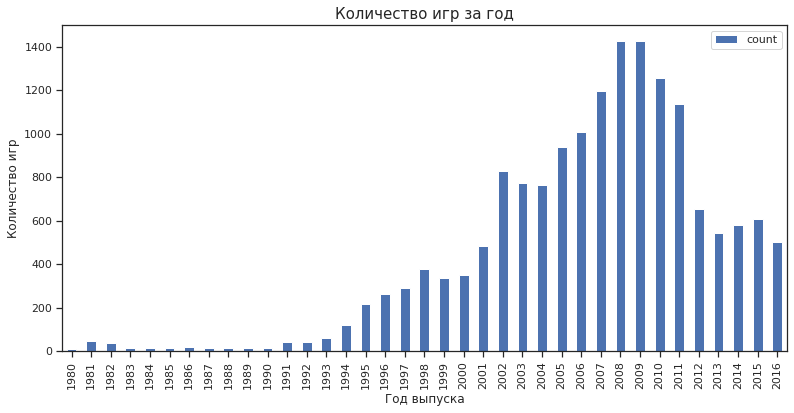

In [25]:
game_year = games.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
game_year.columns = ['year_of_release', 'count']
game_year.plot.bar(x='year_of_release', y='count', figsize=(13,6))
plt.title('Количество игр за год', fontsize=15);
plt.xlabel('Год выпуска', fontsize=12);
plt.ylabel('Количество игр', fontsize=12);

А как менялись продажи за эти годы?

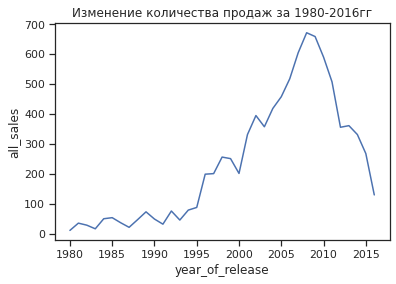

In [26]:
sns.lineplot(
    x='year_of_release', 
    y='all_sales', 
    data=games.groupby('year_of_release').agg({'all_sales': 'sum'}));
plt.title('Изменение количества продаж за 1980-2016гг');

До 2000-х годов количество выпущенных игр за год совсем мало, что и логично: индустрия только начала развиваться, платформ для игр было не так много и производителей тоже. Пик по количеству выпущенных игр и по суммарным продажам приходится на 2007-2011 годы, а затем количество вместе с продажами начинают резко снижаться. Пока не совсем понятно, с чем это связано, может быть, усиленное развитие мобильных игр и пик их популярности так повлияло. Посмотрим, какие платформы представлены в данных.

In [27]:
platforms = games.pivot_table(index='platform', values='all_sales', aggfunc='sum').reset_index()
platforms.columns = ['platform', 'all_sales']
platforms.sort_values(by='all_sales', ascending=False)

,platform,all_sales
16,PS2,1251.44
28,X360,971.07
17,PS3,938.92
26,Wii,905.89
4,DS,805.47
15,PS,729.27
6,GBA,316.46
18,PS4,314.14
19,PSP,292.53
13,PC,259.46


В данном списке на первом месте по продажам стоит PS2, однако надо учитывать, что появилась она в 2000 году, на момент 2016 года уже представлены PS3 и PS4, по продажам они пока отстают, однако в топ-10 входят, связано это, скорее всего, с их более поздним появлением. Такая же ситуация и с Xbox 360 и One. В основном в топе представлены игры для PlayStation, Xbox, различные Nintendo (GBA, Wii, DS), а замыкают десятку лидеров игры на компьютер.
Посмотрим, как менялись платформы в течение последних 10 лет и сколько примерно времени уходит на угасание популярности платформы и появление новой.

In [28]:
top10 = platforms.sort_values(by='all_sales', ascending=False).head(10)
top10 = list(top10['platform'])
top10.append('XOne')
top10.append('WiiU')
top10 = games.query('platform == @top10')
top_10years = top10.query('year_of_release > 2006')#выберем из всего датафрейма только топ10 популярных платформ за последние 10 лет

Дополнительно к 10 лидерам я добавила еще Xbox One, который вышел после 360, и платформу WiiU, которая появилась после Wii, чтобы проверить гипотезу о том, что новые платформы начинают набирать популярность.

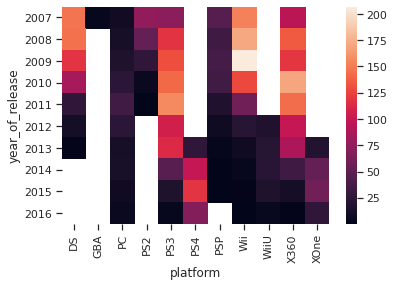

<Figure size 720x504 with 0 Axes>

In [29]:
sns.heatmap(top_10years.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum'));
plt.figure(figsize=(10,7));

Из хитмэпа видно, что большинство платформ имеют регрессивный тип продаж, то есть продажи постепенно снижаются (становятся темнее), в среднем "светлый", то есть популярный период, длится 4 года, затем популярность уходит, так как появляются новые платформы.
Сейчас перспективно развитие PS4 и XOne ввиду их свежести. Однако, по XOne на гарфике всё не так однозначно, он еще не успел захватить популярность, а вот у PS4 видна динамика к увеличению продаж. Также можно обратить внимание на Wii, она была на пике популярности в годы выхода, следует помнить, что в 2016 году Нинтендо представила новую платформу - Switch, однако, пока официального релиза не было, соответственно, и оценить мы не можем.
Если посмотреть на последний ряд хитмэпа - 2016 год - можно заметить, что светлее других явно PS4, XOne и WiiU. Эти платформы и будут наиболее прибыльными. А вот ПК к 2016 году совсем "угас". Жизненый цикл платформы примем за 4 года, соответственно, анализировать данные будем за период с 2013 по 2016.\
*Выберем всё же топ платформ за наиболее актуальный период, а не за все 10 лет.*

In [30]:
top = games.query('year_of_release > 2012').pivot_table(index='platform', 
                                                        values='all_sales', aggfunc='sum') \
.reset_index().sort_values(by='all_sales', ascending=False).head(10)
top

,platform,all_sales
4,PS4,314.14
3,PS3,181.43
10,XOne,159.32
0,3DS,143.25
9,X360,136.80
8,WiiU,64.63
2,PC,39.43
6,PSV,32.99
7,Wii,13.66
5,PSP,3.50


(0.0, 2.0)

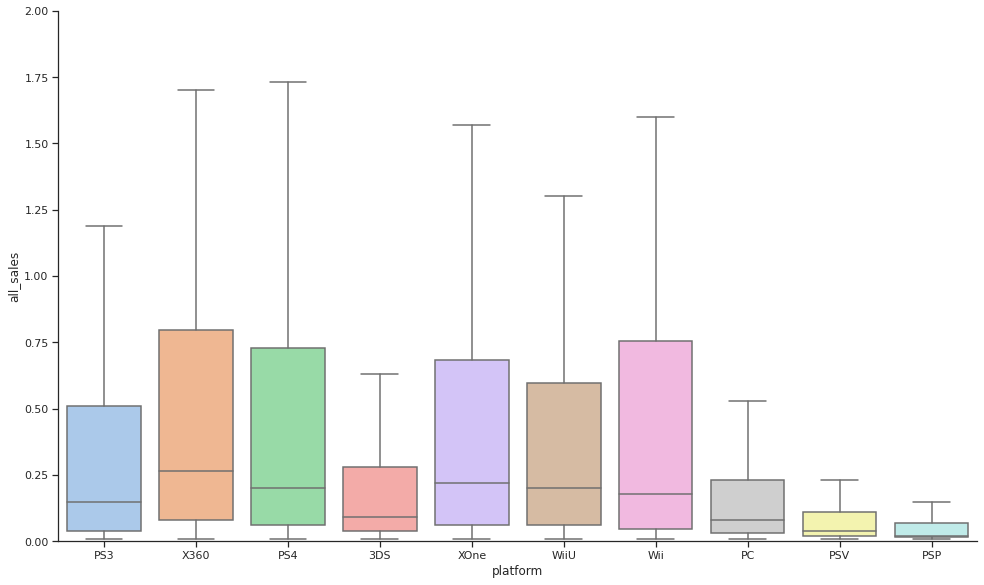

In [31]:
#теперь построим боксплот по популярным плафтформам за последние 4 года
top.columns = ['platform', 'all_sales']
top_platforms = list(top['platform'])
top10_current = games.query('year_of_release > 2012 and platform == @top_platforms')
sns.catplot(
    kind='box',
    data=top10_current,
    x='platform',
    y='all_sales',
    height=8, aspect=1.7,
    orient='v',
    palette='pastel',
    showfliers=False
) 
plt.ylim(0,2)

Сразу обращает на себя внимание размах продаж у PS4, медиана и квартили чуть ниже, чем у других, однако "усы" доходят до максимальных значений, видимо, некоторые игры настолько "выстрелили".\
Совсем немного отстает платформа X360, хоть по медианному значению продажи выше PS4, однако размах усов немного ниже, преемник X360 - XOne тоже имеет довольно большой размах услов и высокое медианное значение продаж. \
Следует обратить внимание на платформу Wii, да, действительно, она показала хорошие продажи, высокие максимальные значения, при этом не стоит забывать про хитмэп - популярность данной платформы уже угасает, ввиду появления новых платформ от этой базы - 3DS и WiiU, которые вышли примерно одновременно с разницей в год. \
А вот ПК и здесь показал себя неперспективной платформой.

**Вывод:** Таким образом мы выявили 3 перспективные платформы для дальнейшего анализа: PS4, XOne и WiiU. Так как средний жизненный цикл платформ около 4 лет, то и актуальным периодом для анализа будут 2013-2016 годы. 

### 3.2 Влияние оценок пользователей и критиков на количество продаж среди лидеров платформ

Для начала построим диаграммы рассеяния и поситаем коэфициент Пирсона для каждой из этих платформ.

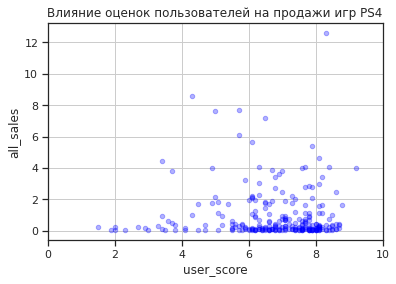

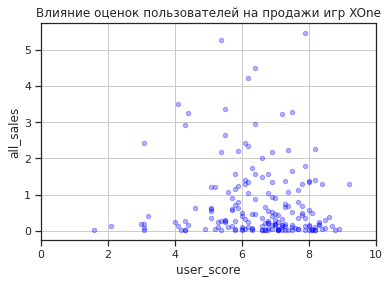

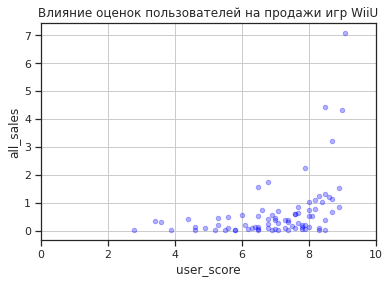

In [32]:
top3_platforms = ['PS4', 'XOne', 'WiiU']
for elem in top3_platforms:
    top10_current.loc[top10_current['platform'] == elem].plot(
        kind='scatter', 
        x='user_score', y='all_sales', 
        grid=True, alpha=0.3,
        xlim=(0,10),
        title=f'Влияние оценок пользователей на продажи игр {elem}',
        c='Blue',
    );

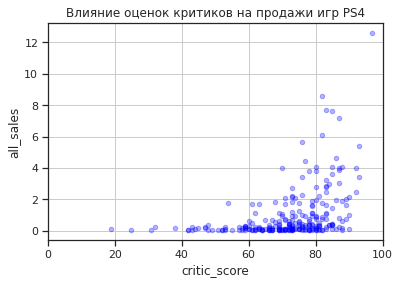

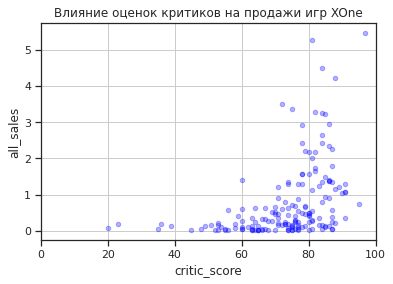

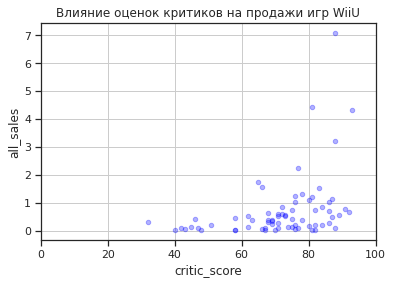

In [33]:
for elem in top3_platforms:    
    top10_current.loc[top10_current['platform'] == elem].plot(
        kind='scatter', 
        x='critic_score', y='all_sales', 
        grid=True, alpha=0.3,
        xlim=(0,100),
        title=f'Влияние оценок критиков на продажи игр {elem}',
        c='Blue'
    );

In [34]:
for elem in top3_platforms:
    print(f'Корреляция между оценками пользователей и критиков для {elem}')
    display(top10_current.loc[top10_current['platform'] == elem][['critic_score', 'user_score', 'all_sales']].corr())

Корреляция между оценками пользователей и критиков для PS4


,critic_score,user_score,all_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
all_sales,0.406568,-0.031957,1.000000


Корреляция между оценками пользователей и критиков для XOne


,critic_score,user_score,all_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
all_sales,0.416998,-0.068925,1.000000


Корреляция между оценками пользователей и критиков для WiiU


,critic_score,user_score,all_sales
critic_score,1.000000,0.721313,0.376415
user_score,0.721313,1.000000,0.419330
all_sales,0.376415,0.419330,1.000000


**Вывод:** Изучив диаграммы рассеяния и коэффициенты Пирсона можем сделать вывод, что на продажи игр PS4 и XOne в большей степени влияют оценки критиков (0.4), парадоксально, что оценки пользователей оказывают даже минимальной обратное влияние на продажи - чем выше оценка, тем ниже продажи. Однако, коэффициенты -0.03 и -0.06 не очень информативны, поэтому можем сказать, что оценки пользователей не влияют на продажи игр PS4 и XOne.\
Немного иначе обстоит дело с играми WiiU - здесь, как мы видим из диаграмм и коэффициента корреляции, оценки пользователей оказывают даже большее влияние на покупку игр, чем оценки критиков (0.4 и 0.3 соответственно).
Таким образом да, оценки критиков влияют на количество продаж среди всех трёх лидеров, при этом игры на WiiU в большей степени зависят и от оценки пользователей, а игры на PS4 и XOne и вовсе не имеют зависимости от пользовательских оценок.

### 3.3 Влияние оценок пользователей и критиков на количество продаж в целом за актуальный период

Чтобы посмотреть, сохраняется ли общая тенденция среди всех платформ, построим диаграммы рассеяния и посчитаем коэффициенты корреляции для всего датафрейма, но за актуальный период с 2013 по 2016 годы.

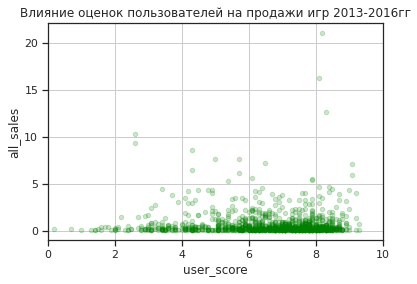

In [35]:
games.query('year_of_release > 2012').plot(
    kind='scatter', 
    x='user_score', y='all_sales', 
    grid=True, alpha=0.2,
    xlim=(0,10),
    title='Влияние оценок пользователей на продажи игр 2013-2016гг',
    c='Green',
);

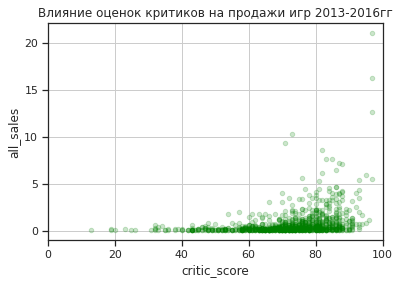

In [36]:
games.query('year_of_release > 2012').plot(
    kind='scatter', 
    x='critic_score', y='all_sales', 
    grid=True, alpha=0.2,
    xlim=(0,100),
    title='Влияние оценок критиков на продажи игр 2013-2016гг',
    c='Green'
);

In [37]:
games.loc[games['year_of_release'] > 2012][['critic_score', 'user_score', 'all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.502221,0.313700
user_score,0.502221,1.000000,-0.002608
all_sales,0.313700,-0.002608,1.000000


**Вывод:** Оценив все игры за 2013-2016 годы мы можем сделать вывод, что здесь сохраняется такая же тенденция, как и среди лидеров: оценка критиков в большей степени влияет на количество продаж, а вот пользовательская оценка вовсе никак не определяет уровень продаж (коэффициенты Пирсона 0.3 и -0.002 соответсвенно).

### 3.4 Влияние жанра на количество продаж игр

Для начала посмотрим, как распределились жанры среди топ10 лидеров.

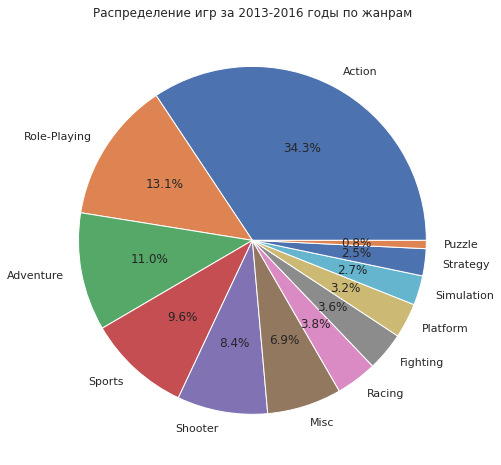

In [38]:
top10_current['genre'].value_counts().plot(kind='pie', 
                                           y='genre', 
                                           figsize=(8,8), 
                                           autopct='%1.1f%%', 
                                           ylabel=' ',
                                           title = 'Распределение игр за 2013-2016 годы по жанрам'
);

Основная масса игр представлена в жанре Экшен - более 30%, затем идут Ролевые игры РПГ и Приключения. Минимальную долю составляют Паззлы.
Посмотрим, есть ли более прибыльные жанры, так как оценивать сумму продаж было бы некорректно (ведь некоторых жанров просто в разы больше), будем оценивать по медианным значениям продаж.

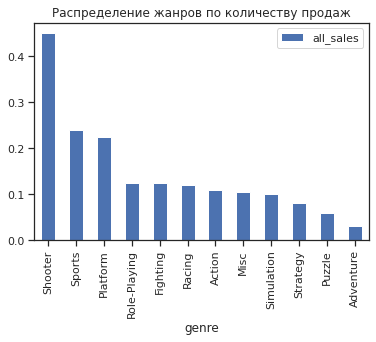

In [39]:
genres = top10_current.groupby('genre').agg({'all_sales':'median'}).reset_index().sort_values(by='all_sales',ascending=False).plot(
                                    kind='bar',
                                    x='genre',
                                    y='all_sales',
                                    rot=0,
                                    title='Распределение жанров по количеству продаж'
                                    );
plt.xticks(rotation=90);

Несмотря на то, что большая часть игр - Экшены, наиболее популяными по количеству продаж являются Шутеры, Экшены и РПГ не вошли даже в тройку лидеров. А вот многочисленные приключения приносят меньше всего прибыли, несмотря на бОльшую распространенность.

**Вывод:** Таким образом, мы выявили, что самые распространенные игры в период 2013-2016 годов - это игры жанров Экшен, РПГ и Приключения. Но при этом наиболее прибыльными по продажам являются Шутеры, Спортивные, Платформеры, РПГ. В то время как распространенные Приключения занимают последнее место по прибыльности. Поэтому нужно быть внимательными - не всегда широко выпускаемые игры являются и максимально прибыльными.

## Шаг 4: Составление портретов пользователя для каждого региона

### 4.1 Топ-5 популярных платформ

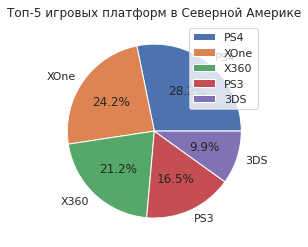

In [40]:
games.query('year_of_release > 2012').groupby('platform').agg({'na_sales': 'sum'}).reset_index().set_index('platform').sort_values(by='na_sales', ascending=False).head().plot(
    kind='pie',
    y='na_sales',
    autopct='%1.1f%%',
    ylabel=' ',
    title='Топ-5 игровых платформ в Северной Америке'
);

Основная масса пятерки лидеров представлена двумя поколениями Xbox - более 45%, примерно третью долю занимает консоль PS4, а вот 3DS от Nintendo не пользуется такой популярностью.

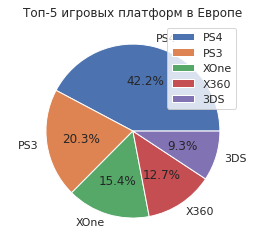

In [41]:
games.query('year_of_release > 2012').groupby('platform').agg({'eu_sales': 'sum'}).reset_index().set_index('platform').sort_values(by='eu_sales', ascending=False).head().plot(
    kind='pie',
    y='eu_sales',
    autopct='%1.1f%%',
    ylabel=' ',
    title='Топ-5 игровых платформ в Европе'
);

В Европе около 60% популярнейших консолей составляет именно PS двух поколений. Xbox занимает уже меньшую долю, в отличие от Америки. Нинтендо по-прежнему на 5 месте.

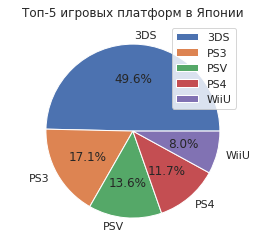

In [42]:
games.query('year_of_release > 2012').groupby('platform').agg({'jp_sales': 'sum'}).reset_index().set_index('platform').sort_values(by='jp_sales', ascending=False).head().plot(
    kind='pie',
    y='jp_sales',
    autopct='%1.1f%%',
    ylabel=' ',
    title='Топ-5 игровых платформ в Японии'
);

Вот как здесь интересно, в Японии почти 50% от популярнейших консолей занимают приставки Нинтендо с платформой 3DS, также в пятерку лидеров попали WiiU того же производителя и несколько консолей от PS. В лидерах Xbox даже не наблюдается.

**Вывод:** \
Большая часть игровых консолей в Америке представлена поколениями Xbox 360 и One. PS и 3DS представлены в меньшей степени. Такое превалирование Xbox легко объяснить тем, что его производитель Microsoft располагается в Америке, поэтому японские консоли не так популярны здесь.\
В Европе Xbox по-прежнему остается в пятерке лидеров, однако более 60% топ-5 консолей представлены платформами PS двух поколений. То есть в европейской части предпочитают устройства от Sony, но и Xbox пользуется большой популярностью. Своих компаний, производящих консоли, в Европе нет.\
А вот в Японии заметно сменилась пятерка лидеров, Xbox здесь вообщне не наблюдается, что ожидаемо, а вот почти 50% занимает платформа от Nintendo - 3DS, также в топ-5 попала и платформа WiiU от того же производителя. И, конечно, более 40% от всех пяти лидеров занимают различные платформы PS, даже PSV, которую в других странах и в общей таблице в лидерах мы не наблюдали. Что и стоило ожидать - все лидеры в Японии представлены Японскими производителями.

### 4.2 Топ-5 популярных жанров

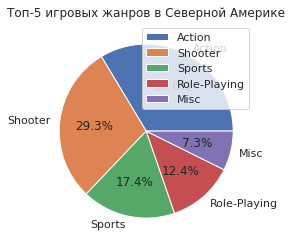

In [43]:
games.query('year_of_release > 2012').groupby('genre').agg({'na_sales': 'sum'}).reset_index().set_index('genre').sort_values(by='na_sales', ascending=False).head().plot(
    kind='pie',
    y='na_sales',
    autopct='%1.1f%%',
    ylabel=' ',
    title='Топ-5 игровых жанров в Северной Америке'
);

В Америке наиболее часто покупают игры жанра Экшен, практически в равных долях они находятся со вторым по популярности жанров - Шутер. В меньшей степени американскому рынку интересны Спортивные и РПГ игры. А аркады замыкают пятерку лидеров.

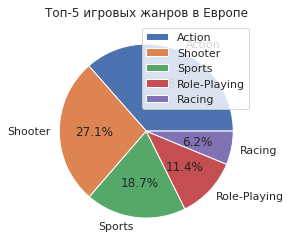

In [44]:
games.query('year_of_release > 2012').groupby('genre').agg({'eu_sales': 'sum'}).reset_index().set_index('genre').sort_values(by='eu_sales', ascending=False).head().plot(
    kind='pie',
    y='eu_sales',
    autopct='%1.1f%%',
    ylabel=' ',
    title='Топ-5 игровых жанров в Европе'
);

В Европе очень похожая картинка с Американским рынком: лидируют Экшены и Шутеры. Только вот замыкают пятерку лидеров здесь гонки. Сложно сказать, с чем связано такое распределение и любовь к одинаковым играм. Может быть, играет роль некоторая схожесть игровых платформ, может быть, связано с похожими производителями для американского и европейского рынка. 

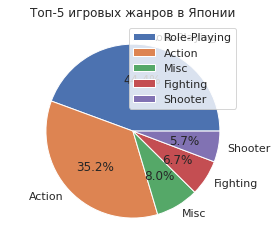

In [45]:
games.query('year_of_release > 2012').groupby('genre').agg({'jp_sales': 'sum'}).reset_index().set_index('genre').sort_values(by='jp_sales', ascending=False).head().plot(
    kind='pie',
    y='jp_sales',
    autopct='%1.1f%%',
    ylabel=' ',
    title='Топ-5 игровых жанров в Японии'
);

А вот в Японии снова разительно отличается распределение по жанрам. РПГ здесь занимают лидирующие позиции, а во Шутеры откатились и замыкают пятерку лидеров.

**Вывод:** \
В целом вкусы по жанрам в Америке и Европе очень похожи - лидируют Экшены, Шутеры, что не противоречит и полученным данным по всему миру. \
А вот в Японии немного другая картинка - ни для кого не секрет, что японцы очень любят игры в жанре РПГ, у них есть множество игр на портативные, стационарные консоли и ПК - на диаграмме мы это и наблюдаем, более 44% игр в пятерке лидеров представлена жанром РПГ. Жанр Экшен в Японии тоже остается популярен, как и в других регионах. А вот Шутеры не пользуются таким спросом и лишь замыкают пятерку лидеров.

### 4.3 Влияние рейтинга ESRB на продажи 

In [46]:
games.query('year_of_release > 2012')['rating'].unique() #посмотрим, какие знаечния есть в этом столбце

array(['M', nan, 'E', 'T', 'E10+'], dtype=object)

Всего в данном рейтинге больше различных оценок, но в наших данных именно с 2013 года осталось небольшое количество категорий, перечислим их, чтобы запомнить и не возвращаться в гугл:
- М - для лиц старше 17 лет
- E - подходит для лиц всех возрастов, в том числе и детей
- T - для лиц старше 13 лет
- E10+ - для лиц старше 10 лет

In [47]:
current_date = games.query('year_of_release > 2012') #создадим отдельную переменную с нужными датами, чтобы было удобнее обращаться

Для начала посмотрим, как вообще распределены игры в зависимости от рейтинга, есть ли сильное превалирование каких-либо игр.

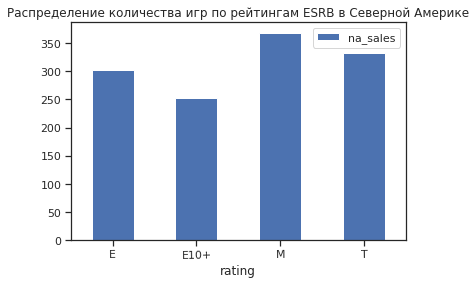

In [48]:
current_date.groupby('rating').agg({'na_sales': 'count'}).reset_index().plot(
    kind='bar',
    x='rating',
    y='na_sales',
    rot=1,
    title='Распределение количества игр по рейтингам ESRB в Северной Америке'
);

Большая часть игр в Северной Америке имеет категорию M - старше 17 лет, однако резкого преобладания какого-либо рейтинга нет, разница по количеству в 50-100 игр. \
Теперь посмотрим на распределение количества продаж в зависиомсти от рейтинга:

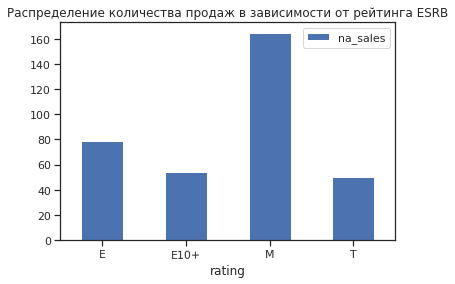

In [49]:
current_date.groupby('rating').agg({'na_sales': 'sum'}).reset_index().plot(
    kind='bar',
    x='rating',
    y='na_sales',
    rot=1,
    title='Распределение количества продаж в зависимости от рейтинга ESRB'
);

Несмотря на незначительное отличие по численности выпущенных игр, разница в суммарных продажах довольно ощутимая: так игры категории M имеют наибольшее количество продаж, а значит, более прибыльны в Северной Америке.\
Посмотрим, будут ли отличия в других регионах:

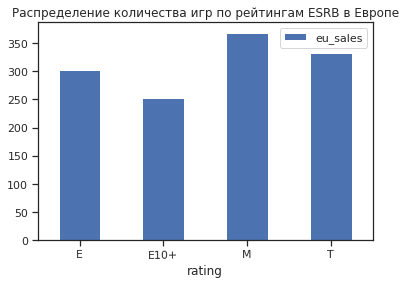

In [50]:
current_date.groupby('rating').agg({'eu_sales': 'count'}).reset_index().plot(
    kind='bar',
    x='rating',
    y='eu_sales',
    rot=1,
    title='Распределение количества игр по рейтингам ESRB в Европе'
);

Интересно, что распределение по количеству игр в зависимости от рейтинга ESRB в Европе аналогично такому распределению в Америке. Посмотрим на продажи:

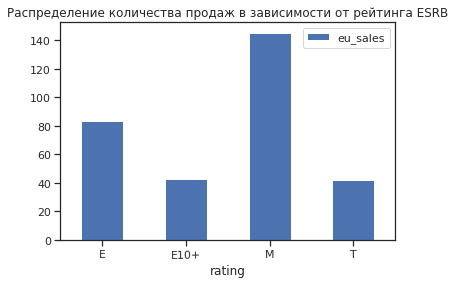

In [51]:
current_date.groupby('rating').agg({'eu_sales': 'sum'}).reset_index().plot(
    kind='bar',
    x='rating',
    y='eu_sales',
    rot=1,
    title='Распределение количества продаж в зависимости от рейтинга ESRB'
);

По продажам в Европе также лидируют игры категории M, причем с таким же значительным отрывом.

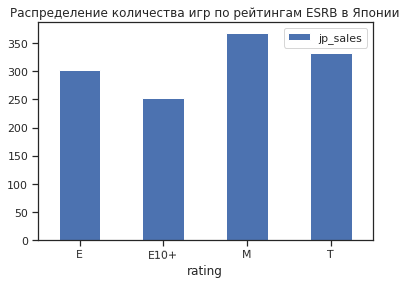

In [52]:
current_date.groupby('rating').agg({'jp_sales': 'count'}).reset_index().plot(
    kind='bar',
    x='rating',
    y='jp_sales',
    rot=1,
    title='Распределение количества игр по рейтингам ESRB в Японии'
);

В Японии количество игр распределено так же, как и в Америке и Европе, посмотрим на продажи:

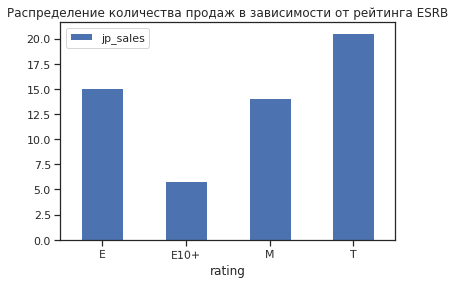

In [53]:
current_date.groupby('rating').agg({'jp_sales': 'sum'}).reset_index().plot(
    kind='bar',
    x='rating',
    y='jp_sales',
    rot=1,
    title='Распределение количества продаж в зависимости от рейтинга ESRB'
);

А вот здесь уже есть отличия: в Японии наиболее прибыльными популярными играми являются игры с рейтингом T - доступные с 13 лет. Но аналогично Европе и Америке игры от 10 лет занимают последнее место по популярности. Зато игры, доступные для всех возрастов, являются более востребованными у японцев, чем в других регионах.

**Вывод:** \
Изучив полученные данные можно сказать, что в Европе и Америке очень похожи распределения игр пок атегориями - наиболее популярными здесь являются игры для взрослых - доступные с 17 лет. \
А вот Япония снова отличилась от других регионов - здесь преобладают игры, доступные с 13 лет, а также бОльшей популярность обладают игры для всех возрастов.\
Но! Следует учитывать, что многие значения в данных были пропущенны, следует помнить, что в Японии и Европе есть свои шкалы для оценки игр по возрастным ограничениям, они могли не войти в анализ.

## Шаг 5: Проверка гипотез

У нас есть две гипотезы, который нужно проверить:
 - средние пользовательские оценки платформ XOne и PC одинаковые
 - средние пользовательские оценки жанров Экшен и Спорт разные

Для проверки первой гипотезы мы примем за нулевую гипотезу то, что средние пользовательские оценки платформ XOne и PC равны. Так как гипотеза односторонняя (нам не важно, больше они или меньше, важно лишь равны или нет), то альтернативная гипотеза будет то, что эти оценки не равны. \
Для проверки нулевой гипотезы будем использовать t-тест Стъюдента для независимых совокупностей и считать гипотезу отвергнутой при p-value менее 0.01. \
У нас нет оснований полагать, что дисперсии двух совокупностей равны, однако мы можем это проверить двумя способами: с помощью возведения в квадрат стандартного отклонения, или с помощью математического подсчета дисперсии с помощью библиотеки numpy. Я выбрала второй способ:

In [54]:
print('Дисперсия PC:', np.var(list(current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='PC'), 'user_score'])))

Дисперсия PC: 3.016306347554631


In [55]:
print('Дисперсия XOne:', np.var(list(current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='XOne'), 'user_score'])))

Дисперсия XOne: 1.8965188383045526


Дисперсии совокупностей не равны.

In [56]:
alpha = 0.01 #критическое значение p-value
result = st.ttest_ind(
    current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='PC'), 'user_score'],
    current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='XOne'), 'user_score'],
    equal_var=False #так как дисперсии не равны
) 

print('Значение p-value:', result.pvalue)

Значение p-value: 0.14759594013430463


In [57]:
#проверяем гипотезу
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')        

Не получилось отвергнуть нулевую гипотезу


In [58]:
#посмотрим математически на средние двух платформ
print('Средняя пользовательская оценка игр на PC', current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='PC'), 'user_score'].mean())
print('Средняя пользовательская оценка игр на XOne', current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='XOne'), 'user_score'].mean())

Средняя пользовательская оценка игр на PC 6.2696774193548395
Средняя пользовательская оценка игр на XOne 6.521428571428572


Построим еще гистограммы для обеих совокупностей для наглядности:

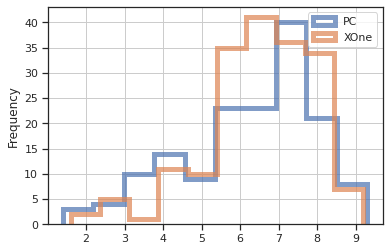

In [59]:
current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='PC'), 'user_score'].plot(
    kind='hist',
    histtype='step',
    alpha=0.7,
    linewidth=5,
    grid=True,
    label='PC',
    legend=True
);

current_date.loc[~(current_date['user_score'].isna()) & (current_date['platform']=='XOne'), 'user_score'].plot(
    kind='hist',
    histtype='step',
    alpha=0.7,
    linewidth=5,
    grid=True,
    label='XOne',
    legend=True
);

На графике видно, что распределения оценок для обеих платформ очень похожи.

**Вывод:** \
Гипотеза о том, что средние оценки пользователей платформ PC и XOne равны, подтвердилась. То есть пользовательский рейтинг игр на обе эти платформы примерно одинаков, однако XOne остается популярной и востребованной платформой, а вот ПК к 2016 году имеет низкие продажи и не рассматривается как потенциально прибыльная платформа. МЫ наблюдали отсутсвие корреляции между оценкой пользователей и количеством продаж, сейчас это еще раз подтвердилось. Не всегда игры, имеющие высокие оценки игроков, хорошо продаются и являются потенциально прибыльными. \
Такой результат можем быть связан с тем, что некоторые игры созданы для любителей контретного жанра или истории, они получаютв высокие оценки от своих игроков, однако, не выходят широко на рынок и не являются популярными.

Вторая гипотеза звучит так: средние оценки пользователей жанров Экшен и Спорт разные. Однако нулевая гипотеза будет обратной - средние оценки игр Экшен и Спорт равны. Гипотеза тоже будет двухсторонняя, так как не важно, какая оценка выше, какая ниже, нам важно лишь наличие разницы. \
И снова мы имеем дело с двумя независимыми совокупностями и будем проверять с помощью t-теста Стъюдента. Для начала проверим дисперсии обеих совокупностей, на этот раз воспользуемся стандартным отклонением:

In [60]:
print('Дисперсия жанр Экшен:', (current_date.loc[~(current_date['user_score'].isna()) 
                                                 & (current_date['genre']=='Action'), 'user_score'].std())**2)

Дисперсия жанр Экшен: 1.7693609042482703


In [61]:
print('Дисперсия жанр Спорт:', (current_date.loc[~(current_date['user_score'].isna()) 
                                                 & (current_date['genre']=='Sports'), 'user_score'].std())**2)

Дисперсия жанр Спорт: 3.180612814465409


Дисперсии снова не равны.

In [62]:
alpha = 0.01 #критическое значение p-value
result = st.ttest_ind(
    current_date.loc[~(current_date['user_score'].isna()) & (current_date['genre']=='Action'), 'user_score'],
    current_date.loc[~(current_date['user_score'].isna()) & (current_date['genre']=='Sports'), 'user_score'],
    equal_var=False #так как дисперсии не равны
) 

print('Значение p-value:', result.pvalue)

Значение p-value: 1.4460039700704315e-20


А вот здесь надо быть внимательным при p-value < 0.01 мы отвергаем нулевую гипотезу. Однако надо помнить, что наша гипотеза из задания противоположна нулевой и говорит о разности двух совокупностей. Значит при овтержении нулевой гипотезы наша гипотеза как раз подвердится

In [63]:
#проверяем гипотезу
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')  

Отвергаем нулевую гипотезу


In [64]:
#посмотрим математически на средние жанров
print('Средняя пользовательская оценка игр жанра Экшен', current_date.loc[~(current_date['user_score'].isna()) & (current_date['genre']=='Action'), 'user_score'].mean())
print('Средняя пользовательская оценка игр жанра Спорт', current_date.loc[~(current_date['user_score'].isna()) & (current_date['genre']=='Sports'), 'user_score'].mean())

Средняя пользовательская оценка игр жанра Экшен 6.837532133676092
Средняя пользовательская оценка игр жанра Спорт 5.238124999999999


И для наглядности построим гистограммы:

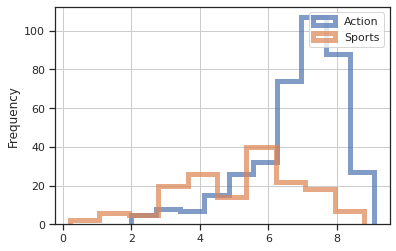

In [65]:
current_date.loc[~(current_date['user_score'].isna()) & (current_date['genre']=='Action'), 'user_score'].plot(
    kind='hist',
    histtype='step',
    alpha=0.7,
    linewidth=5,
    grid=True,
    label='Action',
    legend=True
);

current_date.loc[~(current_date['user_score'].isna()) & (current_date['genre']=='Sports'), 'user_score'].plot(
    kind='hist',
    histtype='step',
    alpha=0.7,
    linewidth=5,
    grid=True,
    label='Sports',
    legend=True
);

А здесь мы и по графику видим, что распределения оценок для двух жанров различны.

**Вывод:** \
Гипотеза о том, что пользовательские оценки жанров Экшен и Спорт различны - подтвердилась. Мы обнаружили, что средний рейтинг игроков игр в жанре Экшен выше, чем у игр жанра Спорт. Экшены и более распространены, за 4 года выпускалось бОльшее количество игр. Хотя следует обратить внимание, что при этом игры жанра Спорт обгоняют Экшены по количеству продаж  во всем мире за эти 4 года, то есть являются более популярными и прибыльными. Что еще раз указывает нам на то, что пользовательский рейтинг не влияет на количество продаж и при планировании рекламных кампаний на него ориентироваться не стоит.

## Шаг 6: Общий вывод и рекомендации для рекламы на 2017 год

**1.** В ходе предобработки данных было выявлено множество прпоусков. Удалены две игры с неизвестными названием и жанром 90х годов, также исключены некоторые игры с неизвестным годом выпуска и отсутствием оценок. Ряд пропусков решено оставить, часть из них можно объяснить отсутсвием рейтинга в виду старости игры или особенностями оценки возрастных ограничений для разных стран. Однако стоит обратить внимание на такое количество пропусков, возможно, это техническая ошибка при выгрузке данных.

**2.** В ходе исследования был определен средний жизненный цикл платформы - 4 года. Более старые платформы теряют популярность и не стоит делать на них акценты во время проведения рекламной кампании. Так было выделены следующие перспективные платформы:
- PS4
- XOne
- WiiU
- 3DS для Японии

Следует обратить внимание на различие предпочтений у разных регионов: так в *Северной Америке* наиболее популярными являются платформы от Xbox, на втором месте PS. В *Европе* PS и Xbox с преобладанием первых. А вот в *Японии* весь топ-5 платформ занимают японские консоли, в том числе портативные, 3DS при этом является абсолютным лидером по популярности у японских пользователей. Следует это учитывать при планировании рекламы на 2017 год и делать акценты на игры для определенных платформ в определенных регионах.

**3.** Наиболее распространенными по количеству выпускаемых игр оказались жанры Экшен, РПГ и Приключения. При этом по количеству продаж жанра Приключения не оказалось ни в одной пятерке лидеров по разным регионам. В статистике по миру Приключения занимают последнее место по прибыльности. На это тоже стоит обратить внимание при проведении рекламы - *не всегда широко распространенные игры являются прибыльными и популярными.* \
Лидерами по продажам в мире стали игры жанра Шутеры, Спорт и Платформы. При этом снова есть некоторые различия по регионам, что необходимо учитывать: в *Северной Америке и Европе* самый популярный по продажам жанр Экшен, также вошли Шутеры, Спорт и РПГ, что, в принципе, соответсвует мировому рейтингу с некоторыми особенностями. А вот в *Японии* картинка немного другая: абсолютными лидерами там являются игры жанра РПГ, также в лидеры вошли Экшен и Аркады, а вот Шутеры здесь менее популярны, это стоит учитывать при планировании рекламы на японский рынок, а также обязательно помнить про любовь японцев к портативным консолям.

**4.** В ходе исследования было также изучено влияние рейтинга ESRB на количество продаж. И обнаружено, что в Северной Америке и Европе предпочитают игры, доступные от 17 лет (M). А вот в Японии отдают предпочтение играм, которые доступны уже с 13 лет (T), и игры категории E - для любого возраста - в Японии более популярны, чем в других странах. При этом игры от 10 лет (E10+) имеют самые низкие продажи во всех регионах. 

**Таким образом** стоит учесть все особенности при проведении рекламы в различным регионах. Северная Америка: платформы XOne в большей степени и PS4, игры категории M жанров Экшен, Шутеры, Спорт, РПГ. В Европе: так же игры от 17 лет в жанрах Экшен, Шутеры, Спорти  РПГ, только уже бОльший акцент на PS4, а затем XOne. А вот в Японии - портативные консоли от Nintendo (3DS, WiiU), консоли от PS, игры, которые дсотупны с более младшего возраста - 13 лет - в жанрах РПГ, Аркады, Экшен.

**5.** Было изучено влияние оценок критиков и пользователей на количество продаж. Установлено, что оценки критиков в большей степени влияют на продажи игр - чем выше оценка, тем выше количество продаж. А вот пользовательский рейтинг, напротив, не определяет популярность. Так, например, установлено, что средний пользовательский рейтинг у игр на ПК и XOne одинаков, однако ПК к 2016 году имеет совсем низкие продажи и не является перспективной платформой, в отличие от XOne. Также было установлено, что игроки более высоко оценивают игры жанра Экшен, чем Спорт, хотя суммарные мировые продажи у Экшенов ниже. Поэтому при планировании рекламной компании не стоит ориентироваться на пользовательский рейтинг, учитывать только оценку критиков.